In [2]:
# Library imports
import pyforest
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint
from time import sleep
import time
import seaborn as sns

from turtle import forward
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, TensorDataset

#### **Hyperparams and data-loading**

In [4]:
train_edges = np.load('../movielens/train_edges.npy')
user_list = train_edges[:, 0]
item_list = train_edges[:, 1]
rating_list = train_edges[:, 2].astype('float32')

n_users = user_list.max() + 1 
n_items = item_list.max() + 1
n_samples = len(rating_list)

n_users, n_items, n_samples

(943, 1682, 200000)

#### **Neural collaborative filtering**

In [30]:
class NCF(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(NCF, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)
        self.fc1 = nn.Linear(n_factors * 2, n_factors)
        self.fc2 = nn.Linear(n_factors, 1)

    def forward(self, user, item):
        tanh = nn.Tanh()
        sigmoid = nn.Sigmoid()

        u = self.user_emb(user)
        i = self.item_emb(item)
        features = torch.concat([u, i], dim = 1)
        x = self.fc1(features)
        # x = tanh(x)
        x = sigmoid(x)
        x = self.fc2(x)
        x = sigmoid(x)
        return x

In [11]:
class CollaborativeFiltering(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(CollaborativeFiltering, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)
        dot = (u * i).sum(1)
        return torch.sigmoid(dot)

In [7]:
def get_accuracy(y_hat, y):
    y = y.clone().int()
    y_hat = (y_hat.clone() > 0.5).int()
    accuracy = (y == y_hat).sum() / len(y)
    return accuracy.item()

#### **Test NCF**

In [38]:
# use gpu 
use_gpu = 6
if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

# load users, items and ratings as tensors
users = torch.tensor(user_list, device = device)
items = torch.tensor(item_list, device = device)
ratings = torch.tensor(rating_list, device = device)
ratings = ratings.reshape((len(ratings), 1))

# define model and it's parameters
n_factors = 64
lr = 3
T = 1000 

model = NCF(n_users, n_items, n_factors)
# model = CollaborativeFiltering(n_users, n_items, n_factors)
model.to(device)
# optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

torch.manual_seed(0)
for layer in model.children():
    layer.reset_parameters()

loss_fn = nn.BCELoss(reduction = 'mean')
model.train()

for i in range(T):
    y_hat = model(users, items)
    loss = loss_fn(y_hat, ratings)
    optimizer.zero_grad()
    loss.backward(retain_graph=True, create_graph=False)
    optimizer.step()
print('lr: ', lr, ' T: ', T, ' loss: ', loss.item(), ' acc: ', get_accuracy(y_hat, ratings))

# LR = 62 and T = 250 seems to do the job very well (for some reason that I don't understand)

lr:  3  T:  1000  loss:  0.4777410328388214  acc:  0.7744649648666382


#### **Meta-attack on NCF (automatic optimization)**

In [61]:
# start execution
start_time = time.time()

# GPU settings (set use_gpu = -1 if you want to use CPU)
use_gpu = 6
if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

# some hyperparams
lr = 50
T = 300
Delta = 5000
n_factors = 64
save_results = False
retain_graph = True 
create_graph = False
manual_gradients = False
dataset = 'movielens'

# list of perturbations
perturbations = dict()
perturbations['edges'] = []
perturbations['metagrad'] = []
perturbations['accuracy_before'] = []
perturbations['accuracy_after'] = []
perturbations['loss_before'] = []
perturbations['loss_after'] = []

# print hyperparam config
print('-> Learning rate: ', lr)
print('-> T: ', T)
print('-> Delta: {} ({}%)'.format(Delta, round(Delta * 100 / n_samples, 2)))
print('-> Embedding size: ', n_factors)
print('-> Device: ', device)
print('-> Retain graph: ', retain_graph)
print('-> Create graph: ', create_graph)
print('-> Save results: ', save_results)

# load users, items and ratings as tensors
users = torch.tensor(user_list, device = device)
items = torch.tensor(item_list, device = device)
ratings = torch.tensor(rating_list, device = device, requires_grad = True)
ratings = ratings.reshape((len(ratings), 1))
perturbs = torch.ones_like(ratings).bool()

# store loss results in this list and later convert to dataframe 
results = []

# define model 
model = NCF(n_users, n_items, n_factors)
model.to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr = lr)
optimizer = torch.optim.Adam(model.parameters())

# for each perturbation do the following
for delta in tqdm(range(Delta), desc='-> Perturbations'):

    # makes loss reproducible for each iteration in Delta
    torch.manual_seed(0)
    for layer in model.children():
        layer.reset_parameters()
    
    # define loss function
    loss_fn = nn.BCELoss(reduction = 'mean')

    model.train()
    for i in range(T):
        y_hat = model(users, items)
        loss = loss_fn(y_hat, ratings)
        results.append([delta, i, loss.item()])

        optimizer.zero_grad()
        loss.backward(retain_graph=retain_graph, create_graph=create_graph)
        optimizer.step()

    # compute and store accuracy of model after T training steps
    with torch.no_grad():
        # compute training accuracy and loss including perturbed edges
        y_hat = model(users, items)
        perturbations['accuracy_before'].append(get_accuracy(y_hat, ratings))
        perturbations['loss_before'].append(loss_fn(y_hat, ratings).item())

        # compute training accuracy and loss excluding perturbed edges
        y_hat_masked = torch.masked_select(y_hat, perturbs)
        ratings_masked = torch.masked_select(ratings, perturbs)
        perturbations['accuracy_after'].append(get_accuracy(y_hat_masked, ratings_masked))
        perturbations['loss_after'].append(loss_fn(y_hat_masked, ratings_masked).item())
    
    # compute meta gradient
    meta_grad = torch.autograd.grad(loss, ratings)[0]

    # select best edge and perform perturbation
    with torch.no_grad():
        mask = ratings.detach().int()
        meta_grad[mask == 1] = 0
        best_edge = meta_grad.argmax().item()
        ratings[best_edge] = 1
        perturbs[best_edge] = False

        # keep track of perturbations and accuracy
        perturbations['edges'].append(best_edge)
        perturbations['metagrad'].append(meta_grad[best_edge].item())

sleep(1)
# compute execution time
exec_time = int(time.time() - start_time)
exec_time = time.strftime("%Hh %Mm %Ss", time.gmtime(exec_time))
print('-> Execution time: {}'.format(exec_time))

# convert results to dataframes for visualisation
results = pd.DataFrame(results, columns = ['perturbs', 'iters', 'loss'])
perturbations = pd.DataFrame(perturbations)
losses = results[results.iters == T - 1][['perturbs', 'loss']].copy()

# save results in CSV format
filename = 'ncf_meta_Delta={}_T={}_LR={}_Factors={}'.format(Delta, T, lr, n_factors) + ('_manual' if manual_gradients else '_auto') + ('_r' if retain_graph else '_c')
if save_results:
    # results.to_csv('results/results_' + filename + '.csv')
    perturbations.to_csv('../results/' + dataset + '/perturbations_' + filename + '.csv')
    losses.to_csv('../results/' + dataset + '/losses_' + filename + '.csv')

-> Learning rate:  50
-> T:  300
-> Delta: 5000 (2.5%)
-> Embedding size:  64
-> Device:  cuda:6
-> Retain graph:  True
-> Create graph:  False
-> Save results:  False


-> Perturbations: 100%|██████████| 5000/5000 [1:25:11<00:00,  1.02s/it]


-> Execution time: 01h 25m 12s


In [ ]:
# Comment: Meta-learning with an adam optimizer attacker is actually working quite well. This one is with T = 200. Try for higher values of T.
# Observation: The performance of the attacker decreases with the number of iterations T.

In [62]:
filename

'ncf_meta_Delta=5000_T=300_LR=50_Factors=64_auto_r'

In [63]:
perturbations.to_csv('../results/' + dataset + '/perturbations_' + filename + '.csv')
losses.to_csv('../results/' + dataset + '/losses_' + filename + '.csv')

In [50]:
perturbations # T = 200

,edges,metagrad,accuracy_before,accuracy_after,loss_before,loss_after
0,89379,0.000022,0.777210,0.777210,0.467764,0.467764
1,134370,0.000020,0.766685,0.766689,0.488671,0.488655
2,70724,0.000019,0.764895,0.764903,0.490875,0.490841
3,116288,0.000019,0.765475,0.765486,0.489574,0.489526
4,151600,0.000019,0.762955,0.762970,0.493471,0.493409
...,...,...,...,...,...,...
4995,108089,0.000011,0.734565,0.753299,0.548225,0.521453
4996,167446,0.000012,0.736330,0.755005,0.545352,0.518442
4997,58757,0.000011,0.736625,0.755404,0.546502,0.519568
4998,60650,0.000011,0.737550,0.756008,0.546358,0.519717


In [64]:
perturbations # T = 300

,edges,metagrad,accuracy_before,accuracy_after,loss_before,loss_after
0,42008,0.000027,0.780130,0.780130,0.452198,0.452198
1,134370,0.000026,0.780415,0.780419,0.454585,0.454567
2,31494,0.000025,0.780455,0.780463,0.456039,0.455996
3,22128,0.000025,0.780035,0.780047,0.455325,0.455260
4,1290,0.000025,0.780345,0.780361,0.456485,0.456400
...,...,...,...,...,...,...
4995,187399,0.000010,0.751680,0.770934,0.522132,0.489522
4996,48007,0.000010,0.752315,0.771589,0.520501,0.488049
4997,188381,0.000010,0.752350,0.771629,0.520670,0.488473
4998,137578,0.000010,0.751250,0.770505,0.520661,0.488845


In [44]:
perturbations.metagrad.max()

2.2339321731124073e-05

#### **Plots**

In [65]:
perturbations_reset = perturbations.reset_index()
perturbations_reset.columns = ['# Perturbations', 'Perturbed edge', 'Meta gradient', 'Accuracy including perturbed edges', 'Accuracy excluding perturbed edges', 'Loss including perturbed edges', 'Loss excluding perturbed edges']
perturbations_reset

,# Perturbations,Perturbed edge,Meta gradient,Accuracy including perturbed edges,Accuracy excluding perturbed edges,Loss including perturbed edges,Loss excluding perturbed edges
0,0,42008,0.000027,0.780130,0.780130,0.452198,0.452198
1,1,134370,0.000026,0.780415,0.780419,0.454585,0.454567
2,2,31494,0.000025,0.780455,0.780463,0.456039,0.455996
3,3,22128,0.000025,0.780035,0.780047,0.455325,0.455260
4,4,1290,0.000025,0.780345,0.780361,0.456485,0.456400
...,...,...,...,...,...,...,...
4995,4995,187399,0.000010,0.751680,0.770934,0.522132,0.489522
4996,4996,48007,0.000010,0.752315,0.771589,0.520501,0.488049
4997,4997,188381,0.000010,0.752350,0.771629,0.520670,0.488473
4998,4998,137578,0.000010,0.751250,0.770505,0.520661,0.488845


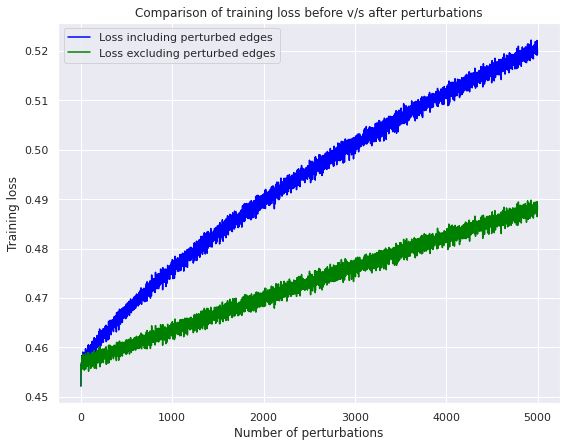

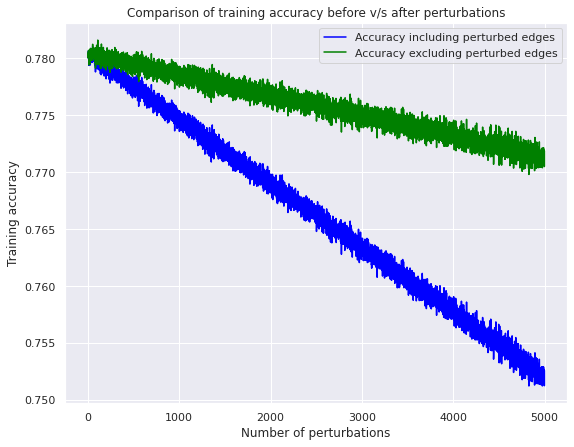

In [66]:
sns.set_theme()
figsize = (9, 7)

# Loss plot

plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss including perturbed edges', color = 'blue').set_title('Comparison of training loss before v/s after perturbations')
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss excluding perturbed edges', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Training loss')
plt.legend(labels = ['Loss including perturbed edges', 'Loss excluding perturbed edges'], loc = 'upper left')
fig.savefig('../plots/' + dataset + '/losses_' + filename)
plt.show()

# Accuracy plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy including perturbed edges', color = 'blue').set_title('Comparison of training accuracy before v/s after perturbations')
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy excluding perturbed edges', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Training accuracy')
plt.legend(labels = ['Accuracy including perturbed edges', 'Accuracy excluding perturbed edges'])
fig.savefig('../plots/' + dataset + '/accuracy_' + filename)
plt.show()